## Aproximate Nearest Neighbor from Scratch

In [20]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
class Tree:
    def __init__(self,
                 children_left = None,
                 children_right = None,
                 size : int = None):
        """Class for store Node

        Args:
            children_left (Tree, optional): 
                Tree for data left. Defaults to None.
            children_right (_type_, optional): 
                Tree for data right. Defaults to None.
            size (int, optional): 
                Count of data point in a tree. Defaults to None.
            is_leaf (bool, optional): 
                Identifier Tree of a leaf. Defaults to False.
        """
        self.children_left = children_left
        self.children_right = children_right
        self.size = size


In [23]:
class ApproximateNearestNeighbor:
    def __init__(self,
                 min_sample_per_branch : int = 10):
        self.min_sample_per_branch = min_sample_per_branch

    def create_index(self,
                     X : np.array,
                     y : np.array) -> None :
        # Pass the data by value
        X = np.array(X).copy()
        y = np.array(X).copy()

        # Grow indexing Tree
        self.tree = self.grow_index(X, y)

    def grow_index(self,
                   X : np.array,
                   y : np.array):
        # calculate node size
        node_size = len(X)

        # create Tree object
        node = Tree(size = node_size)

        # if the node size larger than minimum data
        if node_size.size > self.min_sample_per_branch:
            # split the node
            X_left, X_right, y_left, y_right = self.hyperplane_split(X, y)
            node.children_left = self.grow_index(X_left, y_left)
            node.children_right = self.grow_index(X_right, y_right)
        else:
            # else return the node
            return node

    def hyperplane_split(self,
                         X : np.array,
                         y : np.array):

        # pick 2 random data point from data using
        random_index = np.random.randint(low=0, high=len(data), size=2)
        random_point = X[random_index]

        # calculate the middle point
        random_middle = (random_point[0] + random_point[1])/2

        # vector random point
        vector = random_point[0] - random_point[1]

        # Create the hyperplane equation
        a, b = vector
        c = -(a * random_middle[0] + b * random_middle[1])

        # calculate the sign for every data 
        result_sign = np.sign(np.dot(data, np.array([a, b]).T) + c)

        # separate the data into left and right data
        X_left = X[np.where(result_sign==1)]
        X_right = X[np.where(result_sign==-1)]
        y_left = y[np.where(result_sign==1)]
        y_right = y[np.where(result_sign==-1)]

        return X_left, X_right, y_left, y_right
        

In [2]:
def hyperplane_split(data : np.array):

    # pick 2 random data point from data using
    random_index = np.random.randint(low=0, high=len(data), size=2)
    random_point = data[random_index]

    # calculate the middle point
    random_middle = (random_point[0] + random_point[1])/2

    # vector random point
    vector = random_point[0] - random_point[1]

    # Create the hyperplane equation
    a, b = vector
    c = -(a * random_middle[0] + b * random_middle[1])

    # calculate the sign for every data 
    result_sign = np.sign(np.dot(data, np.array([a, b]).T) + c)

    # separate the data into left and right data
    data_left = data[np.where(result_sign==1)]
    data_right = data[np.where(result_sign==-1)]

    return data_left, data_right

In [7]:
data = np.random.rand(100,2)
data_1, data_2 = hyperplane_split(data)

data.shape, data_1.shape, data_2.shape

((100, 2), (55, 2), (45, 2))

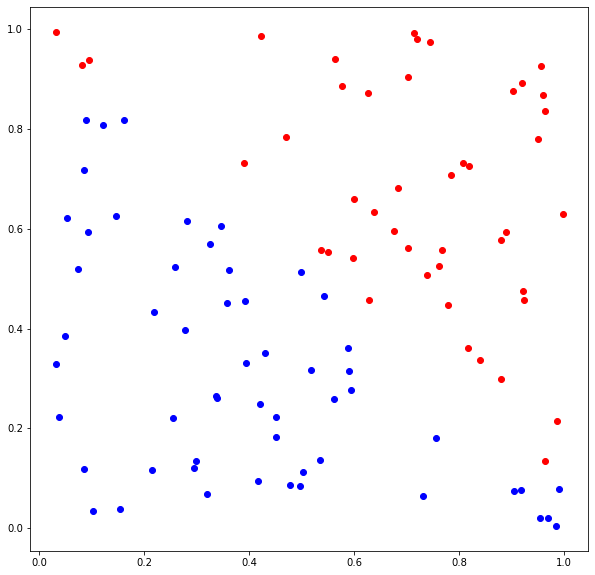

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(data_1[:,0], data_1[:,1], color="blue")
ax.scatter(data_2[:,0], data_2[:,1], color="red")
plt.show()

In [9]:
data_1_1, data_1_2 = hyperplane_split(data_1)
data_2_1, data_2_2 = hyperplane_split(data_2)

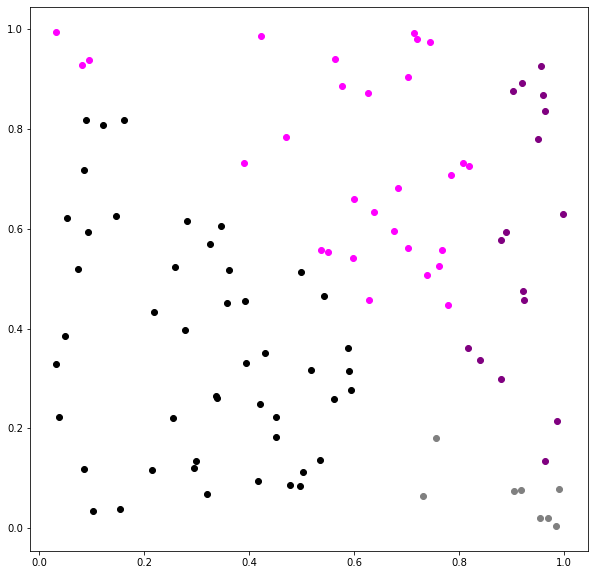

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(data_1_1[:,0], data_1_1[:,1], color="black")
ax.scatter(data_1_2[:,0], data_1_2[:,1], color="grey")
ax.scatter(data_2_1[:,0], data_2_1[:,1], color="purple")
ax.scatter(data_2_2[:,0], data_2_2[:,1], color="magenta")
plt.show()